In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip -q '/content/drive/MyDrive/ IVP_project/archive.zip'

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os


In [5]:
IMAGE_SIZE = [224, 224]

class_1 = os.listdir('/content/yes/')
class_0 = os.listdir('/content/no/')

In [6]:
os.mkdir('/content/train/')
os.mkdir('/content/test/')
os.mkdir('/content/train/yes/')
os.mkdir('/content/train/no/')
os.mkdir('/content/test/yes/')
os.mkdir('/content/test/no/')

In [7]:
import shutil
import random
from sklearn.model_selection import train_test_split
np.random.seed(0)
random.seed(0)
train_1, test_1 = train_test_split(class_1, test_size=0.3,  shuffle = True)
train_0, test_0 = train_test_split(class_0, test_size=0.3, shuffle = True)


for filename in train_1:
    shutil.copy('/content/yes/'+filename, '/content/train/yes/'+filename)

for filename in train_0:
    shutil.copy('/content/no/'+filename, '/content/train/no/'+filename)

for filename in test_1:
    shutil.copy('/content/yes/'+filename, '/content/test/yes/'+filename)

for filename in test_0:
    shutil.copy('/content/no/'+filename, '/content/test/no/'+filename)

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train/',
    target_size=(227, 227),
    shuffle = True,
    batch_size=32)

validation_generator = test_datagen.flow_from_directory(
    '/content/test/',
    target_size=(227, 227),
    batch_size=32)

Found 176 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


In [9]:
from keras.callbacks import EarlyStopping
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from keras import backend as K

In [10]:
SHAPE = (224, 224, 3)
def __init__(self, input_shape, batch_size, orders, base_dir, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape

In [11]:
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [12]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y


In [18]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(2, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [19]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 224, 224, 32  128        ['conv2d_10[0][0]']              
 ormalization)                  )                                                           

In [20]:
#model.build(input_shape = (None,32,32,2))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [21]:
history = model.fit(train_generator,
          epochs=200,
          validation_data=validation_generator)

Epoch 1/200
6/6 [==============================] - 14s 2s/step - loss: 0.7486 - accuracy: 0.5739 - val_loss: 0.6892 - val_accuracy: 0.6104
Epoch 2/200
6/6 [==============================] - 5s 860ms/step - loss: 0.6285 - accuracy: 0.7386 - val_loss: 0.6887 - val_accuracy: 0.7403
Epoch 3/200
6/6 [==============================] - 5s 791ms/step - loss: 0.6071 - accuracy: 0.6818 - val_loss: 0.6952 - val_accuracy: 0.4026
Epoch 4/200
6/6 [==============================] - 5s 797ms/step - loss: 0.5351 - accuracy: 0.7386 - val_loss: 0.7056 - val_accuracy: 0.3896
Epoch 5/200
6/6 [==============================] - 5s 756ms/step - loss: 0.5002 - accuracy: 0.7670 - val_loss: 0.7391 - val_accuracy: 0.3896
Epoch 6/200
6/6 [==============================] - 5s 793ms/step - loss: 0.4898 - accuracy: 0.7443 - val_loss: 0.7466 - val_accuracy: 0.3896
Epoch 7/200
6/6 [==============================] - 5s 798ms/step - loss: 0.4127 - accuracy: 0.8239 - val_loss: 0.7336 - val_accuracy: 0.3896
Epoch 8/200
6/6

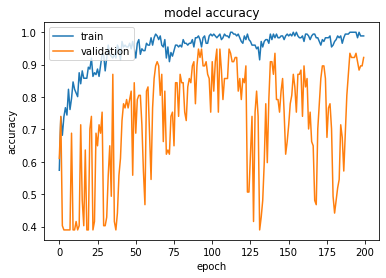

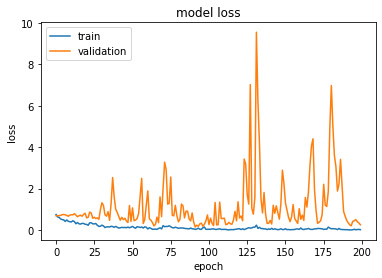

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
model.evaluate(validation_generator)

3/3 [==============================] - 1s 170ms/step - loss: 0.2500 - accuracy: 0.9221


[0.24996870756149292, 0.9220778942108154]

In [24]:
model.evaluate(train_generator)

6/6 [==============================] - 3s 446ms/step - loss: 0.0420 - accuracy: 0.9773


[0.04199420288205147, 0.9772727489471436]